In [1]:
# Initialization of libraries
import torch
import torch.nn
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy.random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as ss
import os

from tqdm import tqdm
import random
from sklearn.mixture import GMM
device = torch.device('cuda')
%matplotlib inline

In [2]:
# defining parameters for the training
mb_size = 256 # Batch Size
Z_dim = 64  # Length of noise vector
X_dim = 1  # Input Length
y_dim = 3
h_dim = 10  # Hidden Dimension
lr = 2e-4    # Learning Rate

In [3]:
def one_hot_embedding(labels, num_classes=3):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels] 


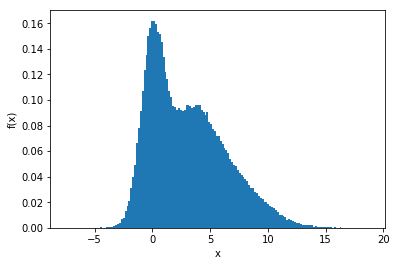

In [4]:
#https://stackoverflow.com/questions/49106806/how-to-do-a-simple-gaussian-mixture-sampling-and-pdf-plotting-with-numpy-scipy

n = 200000
numpy.random.seed(0x5eed)
# Parameters of the mixture components

norm_params = np.array([[0, 1],
                        [3, 2],
                        [6, 3]])

n_components = norm_params.shape[0]
# Weight of each component, in this case all of them are 1/3
weights = np.ones(n_components, dtype=np.float64) / 3.0
# A stream of indices from which to choose the component
mixture_idx = numpy.random.choice(len(weights), size=n, replace=True, p=weights)
# y is the mixture sample
y = numpy.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),dtype=np.float64)

#Theoretical PDF plotting -- generate the x and y plotting positions
# xs = np.linspace(y.min(), y.max(), 200000)
# ys = np.zeros_like(xs)

# for (l, s), w in zip(norm_params, weights):
#     ys += ss.norm.pdf(xs, loc=l, scale=s) * w

#plt.plot(y)
plt.hist(y, normed=True, bins="fd")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [5]:
y_copy = y
data = (y - y.min())/(y.max()-y.min())
g_classes = mixture_idx

In [6]:
G = torch.nn.Sequential(
    torch.nn.Linear(Z_dim + y_dim, h_dim),
    torch.nn.PReLU(),
    torch.nn.Linear(h_dim, h_dim),
    torch.nn.PReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)

D_gan = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, 1),
    torch.nn.Sigmoid()
)

D_aux = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, y_dim)
)

G = G.cuda()
D_gan = D_gan.cuda()
D_aux = D_aux.cuda()

Here, we will gather the parameters of the generator and the discriminator so that they can be given to the Adam optimizer to update the weights

In [7]:
G_solver = optim.Adam(G.parameters(), lr,  betas=(0.0, 0.999))
D_solver = optim.Adam((list(D_gan.parameters()) + list(D_aux.parameters())), lr,  betas=(0.0, 0.999))

adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

ones_label = torch.ones(mb_size,1)
zeros_label = torch.zeros(mb_size,1)
ones_label = ones_label.to(device)
zeros_label = zeros_label.to(device)

In [8]:
# Reset the gradients to zero
params = [G, D_gan, D_aux]
def reset_grad():
    for net in params:
        net.zero_grad()

In [9]:
data_index = 0
for it in tqdm(range(25000)):
    
    # ###
    if ((data_index + 1)*mb_size>len(data)):
        data_index = 0
    # ###
    for diter in range(10):
        z = torch.FloatTensor(mb_size, Z_dim).uniform_(-1, 1)
        X = torch.from_numpy(np.array(data[data_index*mb_size : (data_index + 1)*mb_size]))
        X = X.view(mb_size, 1)
        X = X.type(torch.FloatTensor)

        y = torch.from_numpy(np.array(g_classes[data_index*mb_size : (data_index + 1)*mb_size]))


        y_one_hot = one_hot_embedding(y)
        y_one_hot = y_one_hot.type(torch.FloatTensor)
        y = y.type(torch.LongTensor)

        X = X.to(device)
        z = z.to(device)

        y_one_hot = y_one_hot.to(device)
        y = y.to(device)

        # Dicriminator forward-loss-backward-update
        #forward pass
        G_sample = G(torch.cat([z, y_one_hot], 1))

        D_real_gan = D_gan(X)
        D_real_aux = D_aux(X)

        D_fake_gan = D_gan(G_sample)
        D_fake_aux = D_aux(G_sample)

        # Calculate the loss
        D_loss_real = adversarial_loss(D_real_gan, ones_label) + auxiliary_loss(D_real_aux, y) 
        D_loss_fake = adversarial_loss(D_fake_gan, zeros_label) + auxiliary_loss(D_fake_aux, y) 

        D_loss = D_loss_real + D_loss_fake

        # Calulate and update gradients of discriminator
        D_loss.backward()
        D_solver.step()

        # reset gradient
        reset_grad()
    
    # Generator forward-loss-backward-update

    G_sample = G(torch.cat([z, y_one_hot], 1))
    
    D_fake_gan = D_gan(G_sample)
    D_fake_aux = D_aux(G_sample) 
    D_real_aux = D_aux(X)

    G_loss = adversarial_loss(D_fake_gan, ones_label) + auxiliary_loss(D_real_aux, y) + auxiliary_loss(D_fake_aux, y)

    G_loss.backward()
    G_solver.step()

    # reset gradient
    reset_grad()

    data_index = data_index + 1
    # Print and plot every now and then
    if it % 500 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy()))

  0%|          | 3/25000 [00:01<3:04:39,  2.26it/s]

Iter-0; D_loss: 3.60828924179; G_loss: 3.03533220291


  2%|▏         | 504/25000 [00:25<20:54, 19.52it/s] 

Iter-500; D_loss: 2.18912601471; G_loss: 1.46033096313


  4%|▍         | 1004/25000 [00:50<20:00, 20.00it/s]

Iter-1000; D_loss: 2.09167671204; G_loss: 1.39837324619


  6%|▌         | 1505/25000 [01:14<19:25, 20.15it/s]

Iter-1500; D_loss: 2.14815282822; G_loss: 1.53330540657


  8%|▊         | 2005/25000 [01:38<18:54, 20.26it/s]

Iter-2000; D_loss: 2.14338326454; G_loss: 1.49346494675


 10%|█         | 2503/25000 [02:03<18:26, 20.33it/s]

Iter-2500; D_loss: 2.17390632629; G_loss: 1.52919101715


 12%|█▏        | 3004/25000 [02:27<18:02, 20.32it/s]

Iter-3000; D_loss: 2.06546926498; G_loss: 1.44068622589


 14%|█▍        | 3502/25000 [02:52<17:36, 20.34it/s]

Iter-3500; D_loss: 2.06196522713; G_loss: 1.43901777267


 16%|█▌        | 4004/25000 [03:16<17:10, 20.37it/s]

Iter-4000; D_loss: 2.09969973564; G_loss: 1.45653522015


 18%|█▊        | 4505/25000 [03:41<16:46, 20.37it/s]

Iter-4500; D_loss: 2.00592303276; G_loss: 1.35563850403


 20%|██        | 5003/25000 [04:05<16:21, 20.37it/s]

Iter-5000; D_loss: 2.14966225624; G_loss: 1.54285097122


 22%|██▏       | 5504/25000 [04:30<15:57, 20.36it/s]

Iter-5500; D_loss: 2.1812286377; G_loss: 1.51417815685


 24%|██▍       | 6005/25000 [04:54<15:32, 20.37it/s]

Iter-6000; D_loss: 2.1074051857; G_loss: 1.47207868099


 26%|██▌       | 6504/25000 [05:19<15:07, 20.38it/s]

Iter-6500; D_loss: 2.10796189308; G_loss: 1.46040582657


 28%|██▊       | 7005/25000 [05:43<14:42, 20.39it/s]

Iter-7000; D_loss: 2.24928283691; G_loss: 1.57752394676


 30%|███       | 7503/25000 [06:07<14:17, 20.40it/s]

Iter-7500; D_loss: 2.09075593948; G_loss: 1.46826565266


 32%|███▏      | 8004/25000 [06:32<13:52, 20.41it/s]

Iter-8000; D_loss: 2.14657473564; G_loss: 1.48204052448


 34%|███▍      | 8505/25000 [06:56<13:28, 20.41it/s]

Iter-8500; D_loss: 2.0840985775; G_loss: 1.43947088718


 36%|███▌      | 9004/25000 [07:21<13:03, 20.42it/s]

Iter-9000; D_loss: 2.14135193825; G_loss: 1.48622763157


 38%|███▊      | 9505/25000 [07:45<12:38, 20.42it/s]

Iter-9500; D_loss: 2.10759758949; G_loss: 1.43498110771


 40%|████      | 10005/25000 [08:09<12:13, 20.43it/s]

Iter-10000; D_loss: 2.19310450554; G_loss: 1.51621556282


 42%|████▏     | 10503/25000 [08:34<11:50, 20.42it/s]

Iter-10500; D_loss: 2.05718183517; G_loss: 1.4177159071


 44%|████▍     | 11003/25000 [08:58<11:25, 20.42it/s]

Iter-11000; D_loss: 2.10957670212; G_loss: 1.45496368408


 46%|████▌     | 11503/25000 [09:23<11:01, 20.42it/s]

Iter-11500; D_loss: 2.1597161293; G_loss: 1.51548504829


 48%|████▊     | 12005/25000 [09:47<10:36, 20.42it/s]

Iter-12000; D_loss: 2.13389420509; G_loss: 1.44077062607


 50%|█████     | 12505/25000 [10:12<10:11, 20.42it/s]

Iter-12500; D_loss: 2.09959888458; G_loss: 1.44594836235


 52%|█████▏    | 13004/25000 [10:36<09:47, 20.42it/s]

Iter-13000; D_loss: 2.10398674011; G_loss: 1.44225656986


 54%|█████▍    | 13504/25000 [11:01<09:22, 20.43it/s]

Iter-13500; D_loss: 2.09066057205; G_loss: 1.41666245461


 56%|█████▌    | 14003/25000 [11:25<08:58, 20.42it/s]

Iter-14000; D_loss: 2.06660485268; G_loss: 1.43402218819


 58%|█████▊    | 14504/25000 [11:50<08:33, 20.43it/s]

Iter-14500; D_loss: 2.16722154617; G_loss: 1.50286483765


 60%|██████    | 15003/25000 [12:14<08:09, 20.43it/s]

Iter-15000; D_loss: 2.12708091736; G_loss: 1.48583734035


 62%|██████▏   | 15505/25000 [12:39<07:44, 20.42it/s]

Iter-15500; D_loss: 2.19190311432; G_loss: 1.57500326633


 64%|██████▍   | 16003/25000 [13:03<07:20, 20.43it/s]

Iter-16000; D_loss: 2.17333078384; G_loss: 1.50699388981


 66%|██████▌   | 16505/25000 [13:27<06:55, 20.43it/s]

Iter-16500; D_loss: 2.21346783638; G_loss: 1.56123507023


 68%|██████▊   | 17005/25000 [13:51<06:31, 20.44it/s]

Iter-17000; D_loss: 2.16950702667; G_loss: 1.52551674843


 70%|███████   | 17505/25000 [14:16<06:06, 20.44it/s]

Iter-17500; D_loss: 2.15956449509; G_loss: 1.50691044331


 72%|███████▏  | 18005/25000 [14:40<05:42, 20.44it/s]

Iter-18000; D_loss: 2.01883649826; G_loss: 1.38390266895


 74%|███████▍  | 18503/25000 [15:05<05:17, 20.44it/s]

Iter-18500; D_loss: 2.09494447708; G_loss: 1.46881115437


 76%|███████▌  | 19004/25000 [15:29<04:53, 20.44it/s]

Iter-19000; D_loss: 2.15153813362; G_loss: 1.49895596504


 78%|███████▊  | 19505/25000 [15:54<04:28, 20.44it/s]

Iter-19500; D_loss: 2.15851330757; G_loss: 1.51371753216


 80%|████████  | 20004/25000 [16:18<04:04, 20.44it/s]

Iter-20000; D_loss: 2.12410616875; G_loss: 1.45151376724


 82%|████████▏ | 20502/25000 [16:43<03:40, 20.43it/s]

Iter-20500; D_loss: 2.01113963127; G_loss: 1.3648853302


 84%|████████▍ | 21005/25000 [17:07<03:15, 20.43it/s]

Iter-21000; D_loss: 1.9571441412; G_loss: 1.28509235382


 86%|████████▌ | 21503/25000 [17:32<02:51, 20.43it/s]

Iter-21500; D_loss: 2.21308994293; G_loss: 1.56100749969


 88%|████████▊ | 22006/25000 [17:55<02:26, 20.45it/s]

Iter-22000; D_loss: 2.03979992867; G_loss: 1.36998200417


 90%|█████████ | 22506/25000 [18:12<02:01, 20.59it/s]

Iter-22500; D_loss: 2.14792895317; G_loss: 1.48128211498


 92%|█████████▏| 23005/25000 [18:29<01:36, 20.73it/s]

Iter-23000; D_loss: 2.04763126373; G_loss: 1.41047239304


 94%|█████████▍| 23504/25000 [18:46<01:11, 20.86it/s]

Iter-23500; D_loss: 2.18771576881; G_loss: 1.50516724586


 96%|█████████▌| 24006/25000 [19:03<00:47, 20.99it/s]

Iter-24000; D_loss: 2.07835531235; G_loss: 1.46613729


 98%|█████████▊| 24505/25000 [19:20<00:23, 21.12it/s]

Iter-24500; D_loss: 1.99466705322; G_loss: 1.33105862141


100%|██████████| 25000/25000 [19:36<00:00, 21.24it/s]


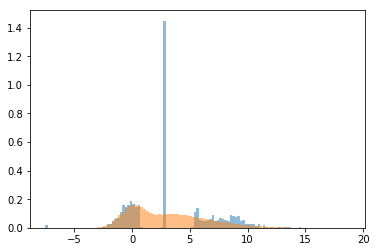

In [10]:
final = np.zeros(1500*mb_size, dtype = float)
for i in range(1500):

    z = torch.FloatTensor(mb_size, Z_dim).uniform_(-1, 1)
    z = z.to(device)

    y = torch.randint(0, 3, (mb_size,)).type(torch.LongTensor)
    y_one_hot = one_hot_embedding(y)
    y_one_hot = y_one_hot.type(torch.FloatTensor)
    y_one_hot = y_one_hot.to(device)
    l = G(torch.cat([z,y_one_hot], 1)).cpu().detach().numpy()
    final[i*mb_size : ((i+ 1)*mb_size -1)] = l[0]

final = y_copy.min() + final*(y_copy.max()-y_copy.min())
fig, ax = plt.subplots( nrows=1, ncols=1 )
p1 = plt.hist(final, 100, normed=True, histtype='stepfilled', alpha=0.5)
p2 = plt.hist(y_copy, 100, normed=True, histtype='stepfilled', alpha=0.5)